### Reference

https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network.py

In [1]:
from __future__ import print_function

import tensorflow as tf

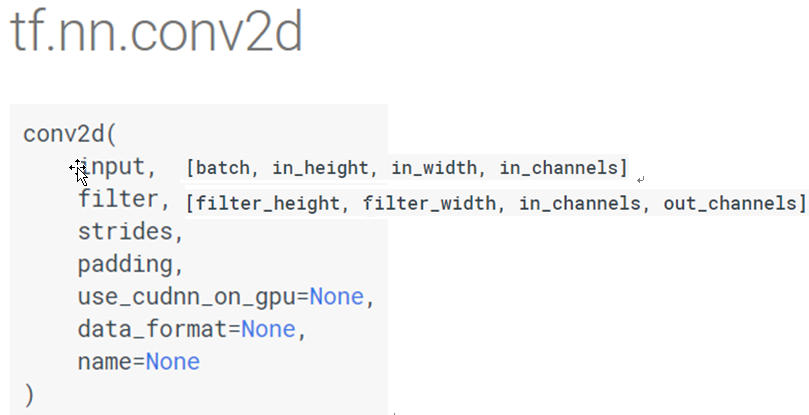

### Input Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Parameters

In [3]:
learning_rate = 0.001
training_iters = 200000
batch_size = 128
display_step = 10
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

### Wrappers

In [7]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    # input = x [batch, in_height, in_width, in_channels]
    # filter = W [filter_height, filter_width, in_channels, out_channels] ==> [5, 5, 1, 32]
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    # n * 768 ==> k * (28 * 28) * 1
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    
    return out

### Placeholders

In [4]:
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

### Variables

In [5]:
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

## Graph

In [8]:
pred = conv_net(x, weights, biases, keep_prob)

#### Loss & Optimizer

In [9]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

#### Evaluation Model

In [10]:
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Launch Graph

In [12]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
        
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1

    print("Optimization Finished!")

    # Calculate accuracy for 256 mnist test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
                                      y: mnist.test.labels[:256],
                                      keep_prob: 1.}))    

Iter 1280, Minibatch Loss= 35524.988281, Training Accuracy= 0.28125
Iter 2560, Minibatch Loss= 12529.324219, Training Accuracy= 0.46875
Iter 3840, Minibatch Loss= 9120.578125, Training Accuracy= 0.60156
Iter 5120, Minibatch Loss= 5755.382324, Training Accuracy= 0.67969
Iter 6400, Minibatch Loss= 2609.859863, Training Accuracy= 0.82812
Iter 7680, Minibatch Loss= 4053.931641, Training Accuracy= 0.76562
Iter 8960, Minibatch Loss= 2805.363281, Training Accuracy= 0.85156
Iter 10240, Minibatch Loss= 3207.331055, Training Accuracy= 0.84375
Iter 11520, Minibatch Loss= 1801.200439, Training Accuracy= 0.88281
Iter 12800, Minibatch Loss= 2561.414307, Training Accuracy= 0.89062
Iter 14080, Minibatch Loss= 1536.830933, Training Accuracy= 0.89062
Iter 15360, Minibatch Loss= 2363.224609, Training Accuracy= 0.91406
Iter 16640, Minibatch Loss= 1530.103516, Training Accuracy= 0.92188
Iter 17920, Minibatch Loss= 1805.967896, Training Accuracy= 0.88281
Iter 19200, Minibatch Loss= 2208.184326, Training Acc

Iter 157440, Minibatch Loss= 247.328873, Training Accuracy= 0.97656
Iter 158720, Minibatch Loss= 198.223175, Training Accuracy= 0.98438
Iter 160000, Minibatch Loss= 126.487556, Training Accuracy= 0.98438
Iter 161280, Minibatch Loss= 267.801147, Training Accuracy= 0.97656
Iter 162560, Minibatch Loss= 285.260254, Training Accuracy= 0.97656
Iter 163840, Minibatch Loss= 429.530029, Training Accuracy= 0.93750
Iter 165120, Minibatch Loss= 198.463074, Training Accuracy= 0.94531
Iter 166400, Minibatch Loss= 68.788116, Training Accuracy= 0.96875
Iter 167680, Minibatch Loss= 341.811005, Training Accuracy= 0.96875
Iter 168960, Minibatch Loss= 159.972412, Training Accuracy= 0.98438
Iter 170240, Minibatch Loss= 247.775864, Training Accuracy= 0.97656
Iter 171520, Minibatch Loss= 152.252808, Training Accuracy= 0.98438
Iter 172800, Minibatch Loss= 297.605896, Training Accuracy= 0.96094
Iter 174080, Minibatch Loss= 148.425308, Training Accuracy= 0.96875
Iter 175360, Minibatch Loss= 195.765930, Training